# Data Collection and preprocessing

## Setup

In [2]:
%load_ext autoreload
%autoreload 2

In [42]:
import sys
from pathlib import Path
import geopandas as gpd
import pandas as pd

# Add the project root to the Python path to import the modules
project_root = Path().absolute().parent
sys.path.append(str(project_root))

In [3]:
from utils.geography_helpers import create_rotated_square_aoi

# Set bounding box for the area of interest (AOI)
create_rotated_square_aoi(
    lat=31.513,
    lon=34.449,
    size_km=4,
    angle_deg=48, 
    filename="../utils/AOI_bboxes/aoi_shifa.geojson"
)

gdf = gpd.read_file("../utils/AOI_bboxes/aoi_shifa.geojson")
print(gdf.geometry[0].wkt)

POLYGON ((34.45033358953366 31.48755359582277, 34.47444640417723 31.51433358953367, 34.44766641046633 31.538446404177233, 34.42355359582277 31.511666410466333, 34.45033358953366 31.48755359582277))


## A/ Sentinel-1 data


The idea here is to download 10 pre-conflict (reference) and 6 post-conflict (post) images of Sentinel-1 (GRD-HD; Polarization: VV+VH).

The images will be distinguished depending on the orbit: Ascending and Descending.

Here are the product names from [ASF Data Search Vertex](https://search.asf.alaska.edu):

Reference images:
S1A_IW_GRDH_1SDV_20230427T154057_20230427T154122_048284_05CE71_87D9 : 27 April 2023, ASCENDING (Orbit 87)
S1A_IW_GRDH_1SDV_20230428T034428_20230428T034453_048291_05CEB1_527A : 28 April 2023, DESCENDING (Orbit 94)
S1A_IW_GRDH_1SDV_20230509T154057_20230509T154122_048459_05D442_3CB6 : 9 May 2023, ASCENDING (Orbit 87)
S1A_IW_GRDH_1SDV_20230510T034429_20230510T034454_048466_05D480_D2F1: 10 May 2023, DESCENDING (Orbit 94)
S1A_IW_GRDH_1SDV_20230521T154058_20230521T154123_048634_05D970_718E: 21 May 2023, ASCENDING (Orbit 87)
S1A_IW_GRDH_1SDV_20230522T034430_20230522T034455_048641_05D9AE_4C24: 22 May 2023, DESCENDING (Orbit 94)
S1A_IW_GRDH_1SDV_20230602T154059_20230602T154124_048809_05DEA1_D36D: 2 June, 2023, ASCENDING (Orbit 87)
S1A_IW_GRDH_1SDV_20230603T034430_20230603T034455_048816_05DEDF_69FD: 3 Juin, 2023, DESCENDING (Orbit 94)

UNOSAT labels:
3 May 2024

Post- images (dates as close to labeling as possible to limit newly destroyed buildings with negative labels)
S1A_IW_GRDH_1SDV_20240503T154102_20240503T154127_053709_068641_952F: 03 May 2024, ASCENDING (Orbit 87)
S1A_IW_GRDH_1SDV_20240504T034434_20240504T034459_053716_06868A_1FEE: 04 May 2024, DESCENDING (Orbit 94)
S1A_IW_GRDH_1SDV_20240515T154102_20240515T154127_053884_068C8C_2024: 15 May 2024, ASCENDING (Orbit 87)
S1A_IW_GRDH_1SDV_20240516T034433_20240516T034458_053891_068CCC_19DD: 16 May 2024, DESCENDING (Orbit 94)
S1A_IW_GRDH_1SDV_20240527T154102_20240527T154127_054059_0692A2_DF93: 27 May 2024, ASCENDING (Orbit 87)
S1A_IW_GRDH_1SDV_20240528T034434_20240528T034459_054066_0692E4_E9D2: 28 May 2024, DESCENDING (Orbit 94)



Each image will undergo and process of 
1. Subsetting: to only keep the area of interest in Gaza City
2. Preprocessing:
    - orbit correction
    - border and thermal noise removal
    - radiometric calibration
    - terrain correction

The script that downloads one product (zip) is ran with:

```console
python scripts/download_single_sentinel_file.py <url>
```

The script that preprocessed the resulting zip is ran with:

```console
python preprocess_single_sentinel_zip.py <path/to/zipfile.zip> <path/to/aoi.geojson> <output_directory> <path/to/snap/gpt>
```

Both scripts have been combined in the `download_process_single_sentinel_file.py` script.

For one URL, the downloading, preprocessing (and deletion of raw file) is done by running:

```console
cd scripts

python download_process_single_sentinel_file.py <url.zip> ../utils/AOI_bboxes/aoi_shifa.geojson ../data/preprocessed/sentinel --snap_gpt_path /Applications/esa-snap/bin/gpt
```

For all the URLs, run the cells in `scripts/download_process_sentinel.ipynb`

## B/ UNOSAT labels

The script in `scripts/download_footprints_UNOSAT` automates the data collection of:

-  building footprings from [Ballinger (2024)](https://github.com/oballinger/PWTT/tree/main?tab=readme-ov-file)
- building damage labels from [UNOSAT](https://unosat.org/products/4047).  

```console
python scripts/download_footprints_UNOSAT
```
 will fetch the data online and save it to `data/raw`.

In [35]:
from utils.preprocessing_UNOSAT_helpers import (
    list_gdb_layers,
    load_unosat_damage_sites,
    process_unosat_damage_labels, 
    create_control_points
)

gdb_path = "../data/raw/labels/UNOSAT_GazaStrip_CDA_25February2025.gdb"
layers = list_gdb_layers(gdb_path)
layer_name = "Damage_Sites_GazaStrip_20250225"
# output_path = "../data/raw/labels/gaza_unosat_labels.geojson"

print(f"\nLayers in the GDB ({len(layers)} layers):")
for i, layer in enumerate(layers):
    print(f"{i+1}. {layer}")

# Load all layers
damage_data = load_unosat_damage_sites()


Layers in the GDB (5 layers):
1. Damage_Sites_GazaStrip_20250225
2. fras_aux_IDP_Sites_Template_FC
3. fras_blk_IDP_Sites_Template_FC
4. fras_bnd_IDP_Sites_Template_FC
5. fras_ras_IDP_Sites_Template_FC
Loading UNOSAT data from: /Users/matteolarrode/Documents/Oxford/Applied ML/Summative/ML-BuildingDamageViaSatellite/data/raw/labels/UNOSAT_GazaStrip_CDA_25February2025.gdb
Loading layer: Damage_Sites_GazaStrip_20250225
Loaded layer 'Damage_Sites_GazaStrip_20250225' with 173350 features
Successfully loaded 173350 damage points

Columns in the damage data:
 - SiteID
 - SensorDate
 - SensorID
 - ConfidenceID
 - Main_Damage_Site_Class
 - SensorDate_2
 - SensorID_2
 - ConfidenceID_2
 - Main_Damage_Site_Class_2
 - Damage_Status_2
 - SensorDate_3
 - SensorID_3
 - ConfidenceID_3
 - Main_Damage_Site_Class_3
 - Damage_Status_3
 - SensorDate_4
 - SensorID_4
 - ConfidenceID_4
 - Main_Damage_Site_Class_4
 - Damage_Status_4
 - SensorDate_5
 - SensorID_5
 - ConfidenceID_5
 - Main_Damage_Site_Class_5
 - 

In [34]:
# Process the damage labels for May 3, 2024 (date index 7)
# Only keeping Destroyed and Severe Damage as positive examples
damage_labels = process_unosat_damage_labels(
    gdf=damage_data, 
    date_index=7,     # Index 7 corresponds to May 3, 2024
    aoi_path="../utils/AOI_bboxes/aoi_shifa.geojson",  # Your AOI
    positive_classes=[1, 2],  # Only 1=Destroyed and 2=Severe Damage are positive
    include_moderate=False    # Don't include moderate damage in the dataset
)

Processing UNOSAT damage labels for date index 7...
Found 136808 valid damage labels for date index 7
Date: 2024-05-03 00:00:00+00:00
Filtered from 136808 to 53507 points (keeping only Destroyed, Severe Damage, and No Visible Damage)
Filtering by AOI: ../utils/AOI_bboxes/aoi_shifa.geojson
Filtered from 53507 to 2966 points within the AOI
Saved processed labels to ../data/processed/labels/damage_labels_20240503.gpkg
Saved CSV version to ../data/processed/labels/damage_labels_20240503.csv

Damage class distribution:
  Destroyed: 1516 (51.1%)
  Severe Damage: 1450 (48.9%)

Total damaged structures: 2966 (100.0%)
Total undamaged structures: 0 (0.0%)


In [39]:
# Create negative control points
control_points = create_control_points(
    damage_labels, 
    aoi_path="../utils/AOI_bboxes/aoi_shifa.geojson",
    min_distance=30,  # 30m minimum distance from damage
    num_points=len(damage_labels)  # Create same number as damage points
)

Generating 2966 control points at least 30m from damage...
Creating damage buffer zone...
Generating random points...
  Made 5000 attempts, found 1596 valid points...
Found 2966 valid control points after 9049 attempts


Text(0.5, 1.0, 'Damage and Control Points')

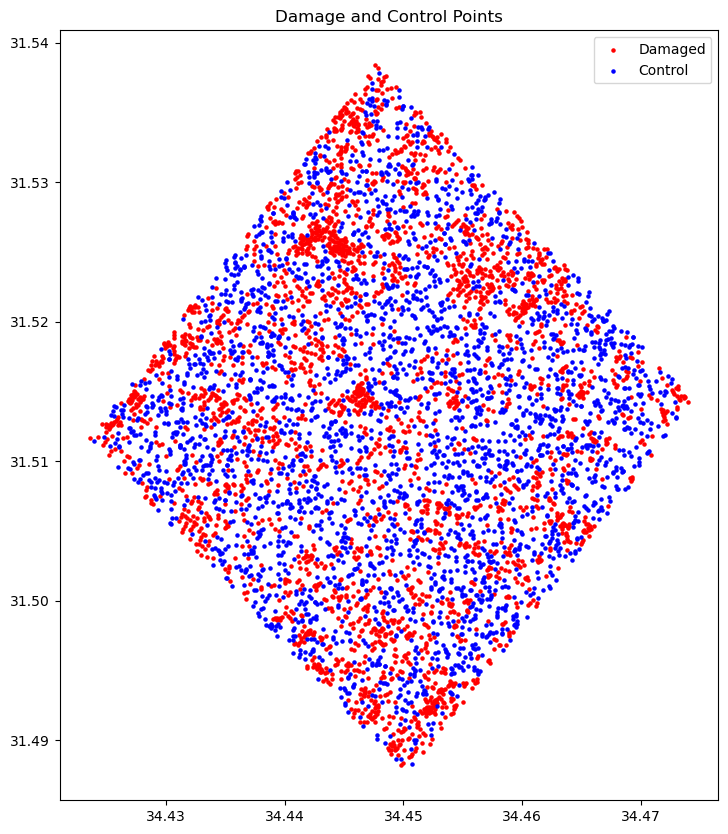

In [40]:
# Visualize the points
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(12, 10))
damage_labels.plot(ax=ax, color='red', markersize=5, label='Damaged')
control_points.plot(ax=ax, color='blue', markersize=5, label='Control')
ax.legend()
plt.title('Damage and Control Points')

Saved combined points to ../data/processed/labels/combined_damage_control_points.gpkg
Saved CSV version to ../data/processed/labels/combined_damage_control_points.csv

Total points: 5932
Points by class:
is_damaged
1    2966
0    2966
Name: count, dtype: int64

Points by damage class:
damage_class_desc
No Visible Damage    2966
Destroyed            1516
Severe Damage        1450
Name: count, dtype: int64


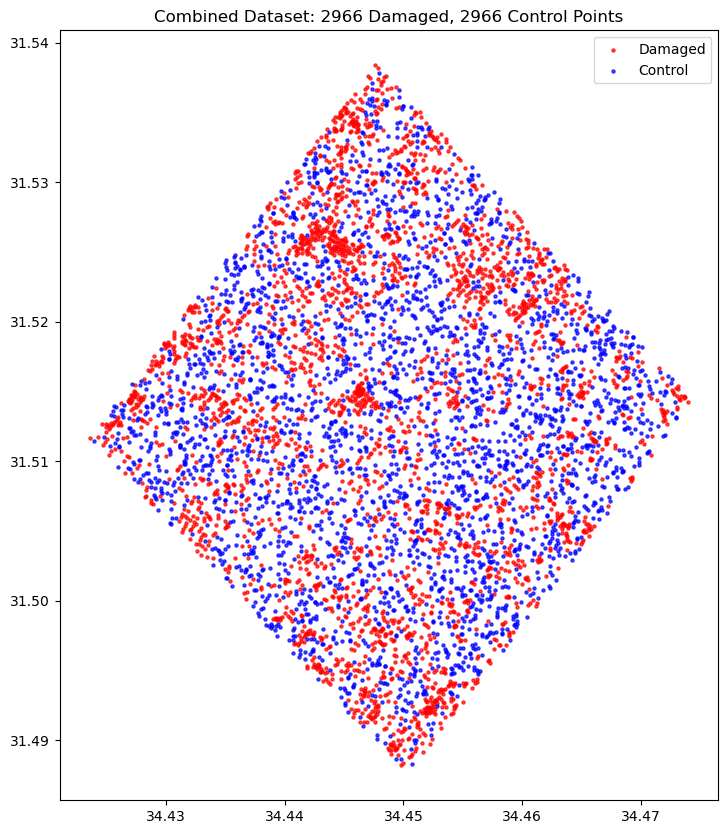

In [43]:
# Combine damage_labels and control_points into a single GeoDataFrame
# Make sure all required columns are in both datasets
required_columns = ['geometry', 'is_damaged', 'damage_class', 'damage_class_desc', 'lon', 'lat']

# Check if control_points has all required columns
for col in required_columns:
    if col not in control_points.columns:
        if col == 'damage_class':
            control_points['damage_class'] = 6  # No Visible Damage
        elif col == 'damage_class_desc':
            control_points['damage_class_desc'] = 'No Visible Damage'
        elif col == 'is_damaged':
            control_points['is_damaged'] = 0
        elif col in ['lon', 'lat'] and 'geometry' in control_points.columns:
            control_points['lon'] = control_points.geometry.x
            control_points['lat'] = control_points.geometry.y

# Same check for damage_labels (just to be safe)
for col in required_columns:
    if col not in damage_labels.columns:
        if col in ['lon', 'lat'] and 'geometry' in damage_labels.columns:
            damage_labels['lon'] = damage_labels.geometry.x
            damage_labels['lat'] = damage_labels.geometry.y

# Combine the dataframes
combined_points = pd.concat([damage_labels, control_points], ignore_index=True)

# Make sure the result is a GeoDataFrame
combined_points = gpd.GeoDataFrame(combined_points, geometry='geometry', crs=damage_labels.crs)

# Visualize the combined points
fig, ax = plt.subplots(figsize=(12, 10))
damage_points = combined_points[combined_points['is_damaged'] == 1]
control_points = combined_points[combined_points['is_damaged'] == 0]

damage_points.plot(ax=ax, color='red', markersize=5, alpha=0.7, label='Damaged')
control_points.plot(ax=ax, color='blue', markersize=5, alpha=0.7, label='Control')
ax.legend()
plt.title(f'Combined Dataset: {len(damage_points)} Damaged, {len(control_points)} Control Points')

# Save the combined GeoDataFrame
output_path = '../data/processed/labels/combined_damage_control_points.gpkg'
combined_points.to_file(output_path, driver='GPKG')
print(f"Saved combined points to {output_path}")

# Also save as CSV for easier use
csv_path = '../data/processed/labels/combined_damage_control_points.csv'
combined_points.drop(columns=['geometry']).to_csv(csv_path, index=False)
print(f"Saved CSV version to {csv_path}")

# Display basic statistics
print(f"\nTotal points: {len(combined_points)}")
print("Points by class:")
print(combined_points['is_damaged'].value_counts())

print("\nPoints by damage class:")
print(combined_points['damage_class_desc'].value_counts())

## C/ Building footprints

The script in `scripts/download_footprints_UNOSAT` automates the data collection of:

-  building footprings from [Ballinger (2024)](https://github.com/oballinger/PWTT/tree/main?tab=readme-ov-file)
- building damage labels from [UNOSAT](https://unosat.org/products/4047).  

```console
python scripts/download_footprints_UNOSAT
```
 will fetch the data online and save it to `data/raw`.